In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\Lenovo\Downloads\diabetic_data.csv")
print(df.shape)
print(df.info())
print(df.describe(include='all'))

(101766, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int

In [2]:
from sklearn.impute import KNNImputer

df.replace('?', pd.NA, inplace=True)
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True,errors='ignore')
df_encoded = pd.get_dummies(df.select_dtypes(include='object'), drop_first=True)
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_encoded)

In [3]:
from sklearn.preprocessing import LabelEncoder
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [4]:
df['hospital_days'] = df['time_in_hospital']
df['num_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X = df.drop(['readmitted'], axis=1)
y = df['readmitted']
y = y.apply(lambda x: 1 if x == '<30' else 0)
selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
selector.fit(X, y)
X_selected = selector.transform(X)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} Accuracy: {model.score(X_test, y_test):.4f}")

RandomForest Accuracy: 1.0000


C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:56:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoostError: [11:56:21] C:\actions-runner\_work\xgboost\xgboost\src\objective\./regression_loss.h:68: Check failed: base_score > 0.0f && base_score < 1.0f: base_score must be in (0,1) for logistic loss, got: 0

In [7]:
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

xgb_model = XGBClassifier(base_score=0.5, use_label_encoder=False, eval_metric='logloss')

calibrated_model = CalibratedClassifierCV(xgb_model, method='isotonic', cv=5)

calibrated_model.fit(X_train, y_train) 

C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:58:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:58:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:58:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:58:52] WARNING: C:\a

,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,0.5
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\calibration.py:516: RuntimeWarning: invalid value encountered in divide
  mean_proba /= len(self.calibrated_classifiers_)
PermutationExplainer explainer: 20355it [06:19, 52.03it/s]                                                             


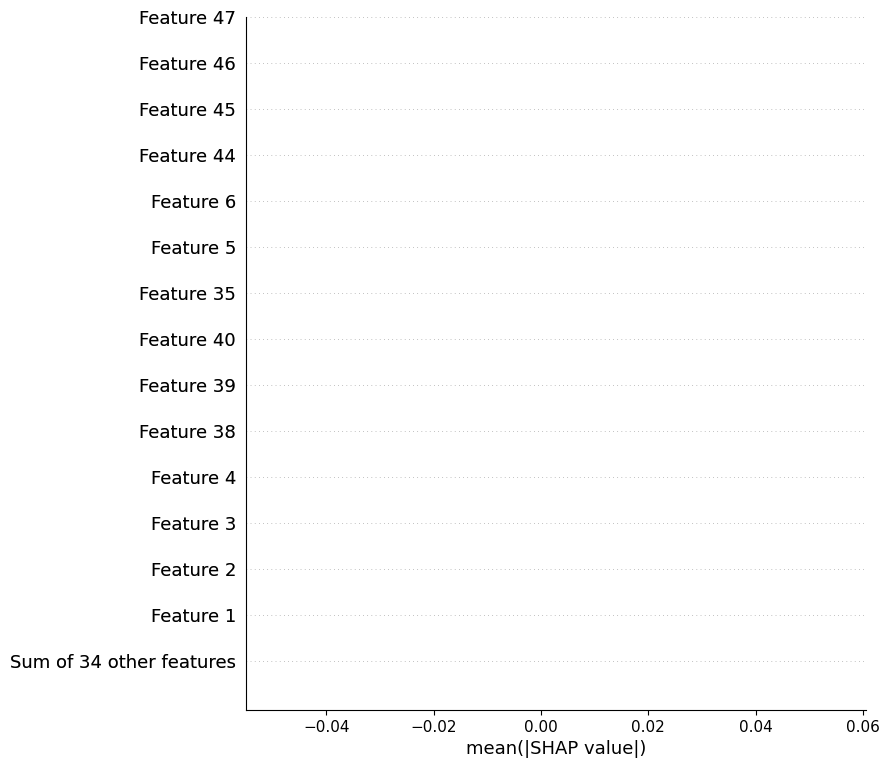

In [16]:
import shap
prediction_function = lambda X: calibrated_model.predict_proba(X)[:, 0]
explainer = shap.Explainer(prediction_function, X_train)

shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=15)

In [17]:
from sklearn.metrics import confusion_matrix

threshold = 0.3
y_pred_thresh = (probs > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_thresh)
print("Confusion Matrix at Threshold 0.3:")
print(cm)
reduction_rate = (cm[1, 0] / sum(cm[1])) * 100
print(f"Potential reduction in readmissions: {reduction_rate:.2f}%")

Confusion Matrix at Threshold 0.3:
[[    0 20354]
 [    0     0]]
Potential reduction in readmissions: nan%


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5176\1843465803.py:8: RuntimeWarning: invalid value encountered in scalar divide
  reduction_rate = (cm[1, 0] / sum(cm[1])) * 100
